<a href="https://colab.research.google.com/github/tkasod2/TIL/blob/main/prj_analysis/Retailrocket_recommender_system_datase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

data link : https://www.kaggle.com/retailrocket/ecommerce-dataset


## Context
The dataset consists of three files: a file with behaviour data (events.csv), a file with item properties (itemproperties.сsv) and a file, which describes category tree (categorytree.сsv). The data has been collected from a real-world ecommerce website. It is raw data, i.e. without any content transformations, however, all values are hashed due to confidential issues. The purpose of publishing is to motivate researches in the field of recommender systems with implicit feedback.

## Content
The behaviour data, i.e. events like clicks, add to carts, transactions, represent interactions that were collected over a period of 4.5 months. A visitor can make three types of events, namely “view”, “addtocart” or “transaction”. In total there are 2 756 101 events including 2 664 312 views, 69 332 add to carts and 22 457 transactions produced by 1 407 580 unique visitors. For about 90% of events corresponding properties can be found in the “item_properties.csv” file.

For example:

“1439694000000,1,view,100,” means visitorId = 1, clicked the item with id = 100 at 1439694000000 (Unix timestamp)
“1439694000000,2,transaction,1000,234” means visitorId = 2 purchased the item with id = 1000 in transaction with id = 234 at 1439694000000 (Unix timestamp)
The file with item properties (item_properties.csv) includes 20 275 902 rows, i.e. different properties, describing 417 053 unique items. File is divided into 2 files due to file size limitations. Since the property of an item can vary in time (e.g., price changes over time), every row in the file has corresponding timestamp. In other words, the file consists of concatenated snapshots for every week in the file with the behaviour data. However, if a property of an item is constant over the observed period, only a single snapshot value will be present in the file.
For example, we have three properties for single item and 4 weekly snapshots, like below:

Because property=100 is constant over time, property=200 has different values for all snapshots, property=300 has been changed once.

Item properties file contain timestamp column because all of them are time dependent, since properties may change over time, e.g. price, category, etc. Initially, this file consisted of snapshots for every week in the events file and contained over 200 millions rows. We have merged consecutive constant property values, so it's changed from snapshot form to change log form. Thus, constant values would appear only once in the file. This action has significantly reduced the number of rows in 10 times.

All values in the “item_properties.csv” file excluding "categoryid" and "available" properties were hashed. Value of the "categoryid" property contains item category identifier. Value of the "available" property contains availability of the item, i.e. 1 means the item was available, otherwise 0. All numerical values were marked with "n" char at the beginning, and have 3 digits precision after decimal point, e.g., "5" will become "n5.000", "-3.67584" will become "n-3.675". All words in text values were normalized (stemming procedure: https://en.wikipedia.org/wiki/Stemming) and hashed, numbers were processed as above, e.g. text "Hello world 2017!" will become "24214 44214 n2017.000"

The category tree file has 1669 rows. Every row in the file specifies a child categoryId and the corresponding parent.
For example:

Line “100,200” means that categoryid=1 has parent with categoryid=200
Line “300,” means that categoryid hasn’t parent in the tree
## Acknowledgements
Retail Rocket (retailrocket.io) helps web shoppers make better shopping decisions by providing personalized real-time recommendations through multiple channels with over 100MM unique monthly users and 1000+ retail partners over the world.

## Inspiration
How to use item properties and category tree data to improve collaborative filtering model?
Recurrent Neural Networks with Top-k Gains for Session-based Recommendations https://github.com/hidasib/GRU4Rec and paper https://arxiv.org/abs/1706.03847
https://www.researchgate.net/publication/280538158_Application_of_Kullback-Leibler_divergence_for_short-term_user_interest_detection
https://pdfs.semanticscholar.org/66dc/1724c4ed1e74fe6b22e636b52031a33c8ebe.pdf https://www.slideshare.net/LukasLerche/adaptation-and-evaluation-of-recommendationsfor-shortterm-shopping-goals Adaptation and Evaluation of Recommendations for Short-term Shopping Goals
## Tasks
### Task 1
When a customer comes to an e-commerce site, he looks for a product with particular properties: price range, vendor, product type and etc. These properties are implicit, so it's hard to determine them through clicks log.

Try to create an algorithm which predicts properties of items in "addtocart" event by using data from "view" events for any visitor in the published log.

### Task 2
#### Description:
Process of analyzing ecommerce data include very important part of data cleaning. Researchers noticed that in some cases browsing data include up to 40% of abnormal traffic.

Firstly, abnormal users add a lot of noise into data and make recommendation system less effective. In order to increase efficiency of recommendation system, abnormal users should be removed from the raw data.

Secondly, abnormal users add bias to results of split tests, so this type of users should be removed also from split test data.

#### Goals:
The main goal is to find abnormal users of e-shop.

#### Subgoals:
Generate features
Build a model
Create a metric that helps to evaluate quality of the model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# !unzip -qq '/content/drive/MyDrive/공부/Kaggle/eCommerce behavior data from multi category store.zip' -d '/content/drive/MyDrive/공부/Kaggle/eCommerce behavior data from multi category store'

# # GPU Check
# !nvidia-smi

# # CPU Check
# !head /proc/cpuinfo

# # RAM
# !head -n 3 /proc/meminfo

Mounted at /content/drive


In [3]:
import pandas as pd
import os

In [4]:
PATH = '/content/drive/MyDrive/공부/Kaggle/Retailrocket recommender system dataset/'

FILES = list(os.listdir(PATH))
FILES = [x.split('.csv')[0] for x in FILES]

def readcsv(x):
  return pd.read_csv(PATH + x)

for i in FILES:
  globals()[f'df_{i}'] = readcsv(i+'.csv') # 전역변수 사용해서, data 읽어오기

In [5]:
import datetime
def ts_to_dt(df):
  for col in df.columns:
    if col == 'timestamp':
      df['datetime'] = (df['timestamp']/1000).apply(datetime.datetime.fromtimestamp) # timestamp에서 datetime 으로 바꿀때 1000을 나눠줘야한다.
      df['date'] = df['datetime'].dt.strftime('%Y-%m-%d')
    else:
      pass
  return df

In [6]:
events = ts_to_dt(df_events)

In [7]:
item_pro1 = ts_to_dt(df_item_properties_part1)
item_pro2 = ts_to_dt(df_item_properties_part2)
item_pro2.head()

,timestamp,itemid,property,value,datetime,date
0,1433041200000,183478,561,769062,2015-05-31 03:00:00,2015-05-31
1,1439694000000,132256,976,n26.400 1135780,2015-08-16 03:00:00,2015-08-16
2,1435460400000,420307,921,1149317 1257525,2015-06-28 03:00:00,2015-06-28
3,1431831600000,403324,917,1204143,2015-05-17 03:00:00,2015-05-17
4,1435460400000,230701,521,769062,2015-06-28 03:00:00,2015-06-28


In [8]:
df_item = pd.concat([item_pro1, item_pro2],ignore_index = True)
df_item.head()

,timestamp,itemid,property,value,datetime,date
0,1435460400000,460429,categoryid,1338,2015-06-28 03:00:00,2015-06-28
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 03:00:00,2015-09-06
2,1439089200000,395014,400,n552.000 639502 n720.000 424566,2015-08-09 03:00:00,2015-08-09
3,1431226800000,59481,790,n15360.000,2015-05-10 03:00:00,2015-05-10
4,1431831600000,156781,917,828513,2015-05-17 03:00:00,2015-05-17


In [9]:
events.columns

Index(['timestamp', 'visitorid', 'event', 'itemid', 'transactionid',
       'datetime', 'date'],
      dtype='object')

### ✅events

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

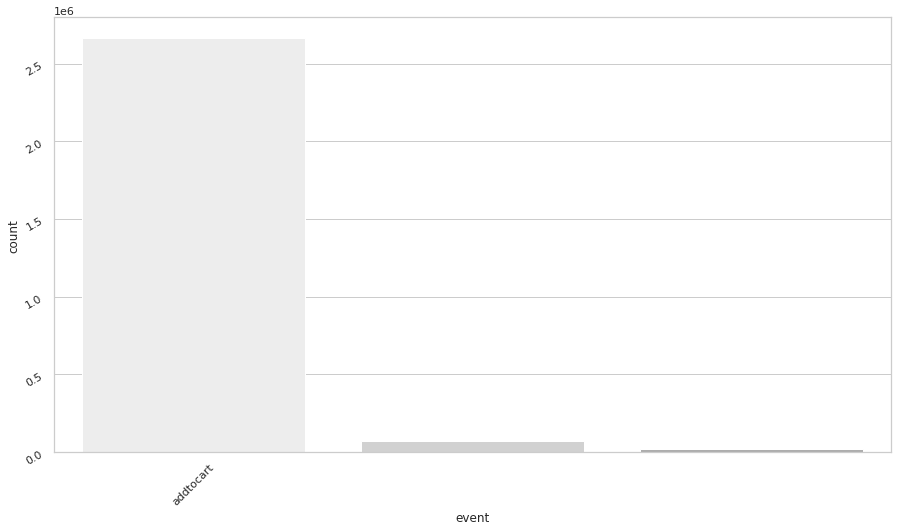

In [18]:
# events['event']
sns.set_theme(style="whitegrid", palette="Greys")
plt.xticks(rotation=45)
plt.yticks(rotation=30) 

g = sns.countplot(x='event',data =events)
g.figure.set_size_inches(15, 8)
g.xaxis.set_major_locator(ticker.MultipleLocator(3))


In [19]:
# event and transactionid
# # df['event'].value_counts()
# # # view           2664312
# # # addtocart        69332
# # # transaction      22457


# event가 transaction인 경우에만 transactionid가 존재한다.
events.groupby('event')['transactionid'].count().reset_index().rename(columns = {'transaction_id' :'cnt_transaction_id'})


,event,transactionid
0,addtocart,0
1,transaction,22457
2,view,0


In [20]:
events.sort_values('timestamp',inplace=True)
events.reset_index(drop=True, inplace = True)
events.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,date
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03


In [21]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      int64         
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
 5   datetime       datetime64[ns]
 6   date           object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 147.2+ MB


#### DAU, MAU, WAU, DAU/MAU

In [22]:
events['month'] = events['datetime'].dt.strftime('%m')
events['week'] = events['datetime'].dt.strftime('%Y-w%U')
events.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,05,2015-w18
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,05,2015-w18
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,05,2015-w18
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,05,2015-w18
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,05,2015-w18


In [23]:
DAU = events.groupby('date')['visitorid'].count().reset_index().rename(columns = {'visitorid':'cnt_visit'})
DAU.head()

,date,cnt_visit
0,2015-05-03,13683
1,2015-05-04,19414
2,2015-05-05,23015
3,2015-05-06,23920
4,2015-05-07,23164


Text(0, 0.5, 'User_cnt')

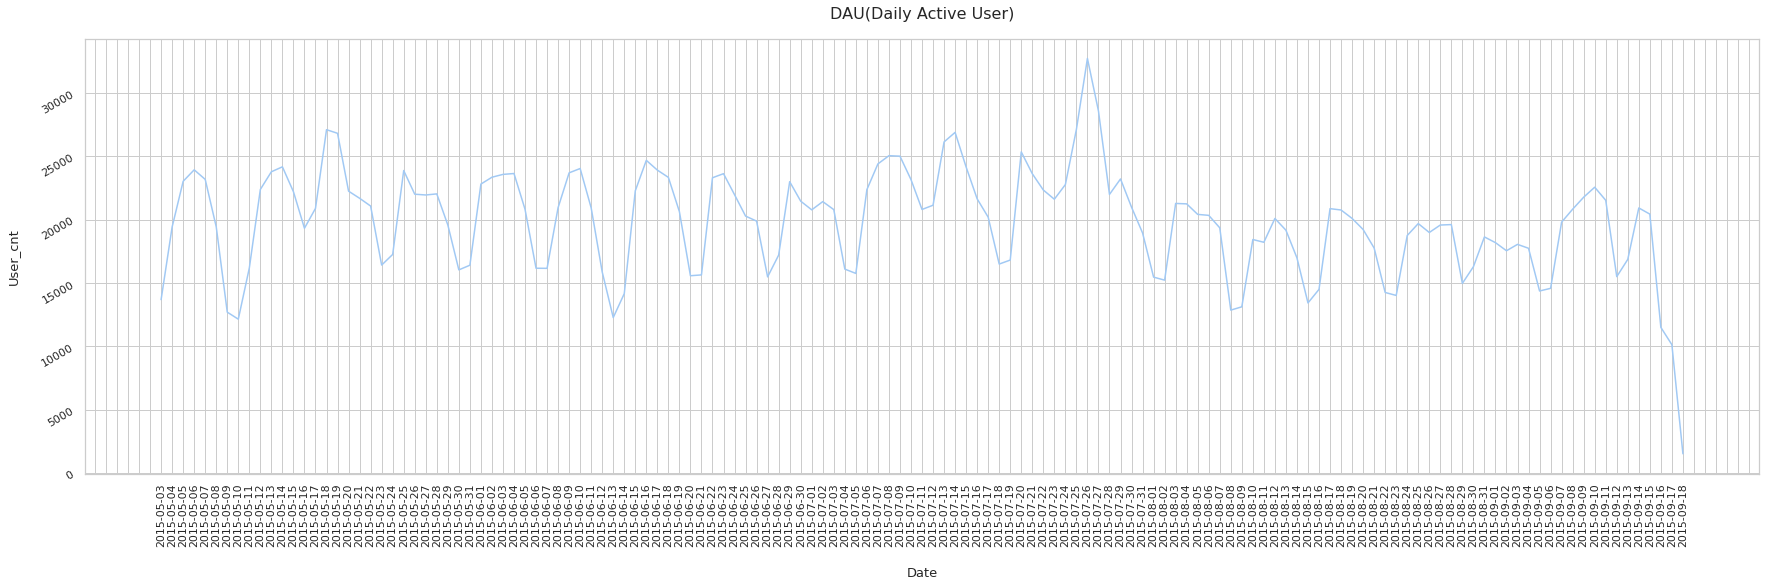

In [24]:
sns.set_theme(style="whitegrid", palette="pastel")
plt.xticks(rotation=90)
plt.yticks(rotation=30) 

g = sns.lineplot(x='date', y='cnt_visit',data =DAU)
g.figure.set_size_inches(30, 8)
g.xaxis.set_major_locator(ticker.MultipleLocator(1))

g.set_title("DAU(Daily Active User)", pad=20, size=16)
g.set_xlabel("Date",labelpad = 20, size = 13)
g.set_ylabel("User_cnt",labelpad = 20, size = 13)

Text(0, 0.5, 'User_cnt')

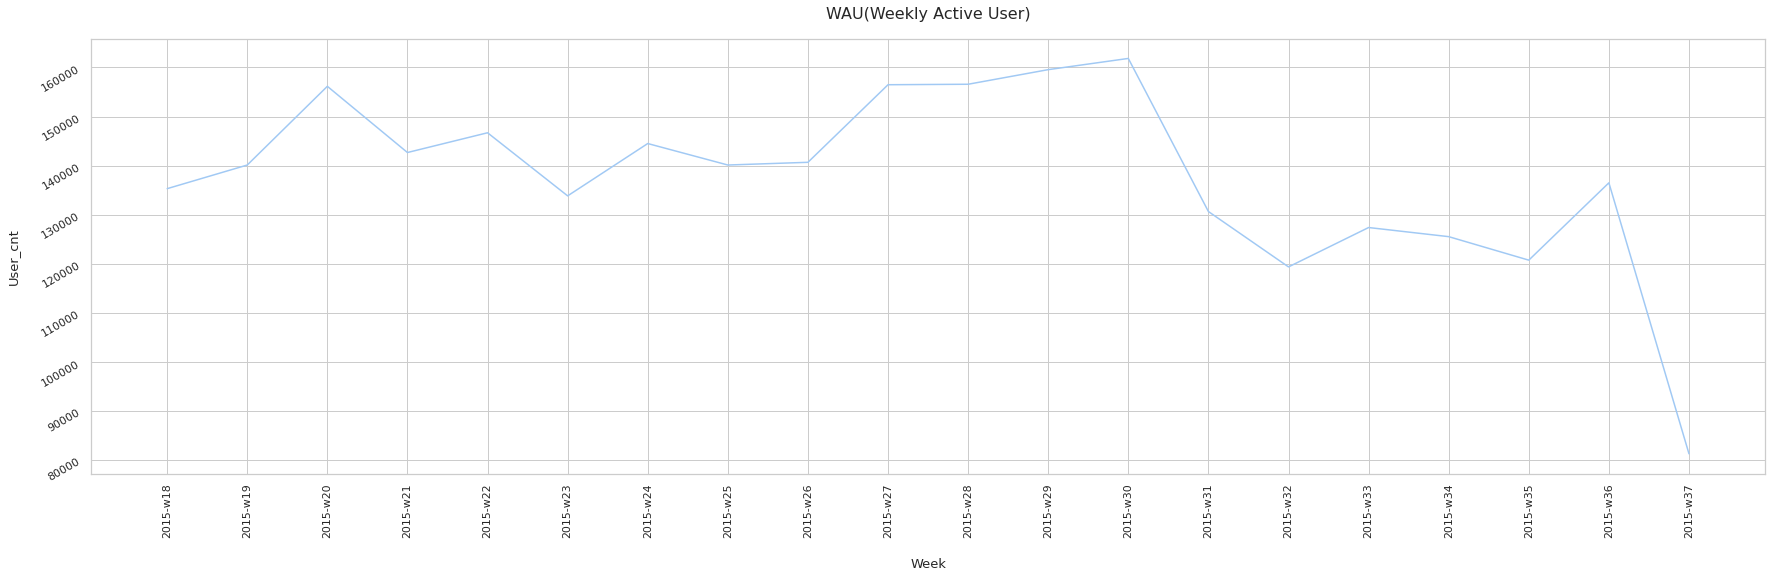

In [25]:
# WAU
WAU = events.groupby('week')['visitorid'].count().reset_index().rename(columns = {'visitorid':'cnt_visit'})

sns.set_theme(style="whitegrid", palette="pastel")
plt.xticks(rotation=90)
plt.yticks(rotation=30) 

g = sns.lineplot(x='week', y='cnt_visit',data =WAU)
g.figure.set_size_inches(30, 8)
g.xaxis.set_major_locator(ticker.MultipleLocator(1))

g.set_title("WAU(Weekly Active User)", pad=20, size=16)
g.set_xlabel("Week",labelpad = 20, size = 13)
g.set_ylabel("User_cnt",labelpad = 20, size = 13)

Text(0, 0.5, 'User_cnt')

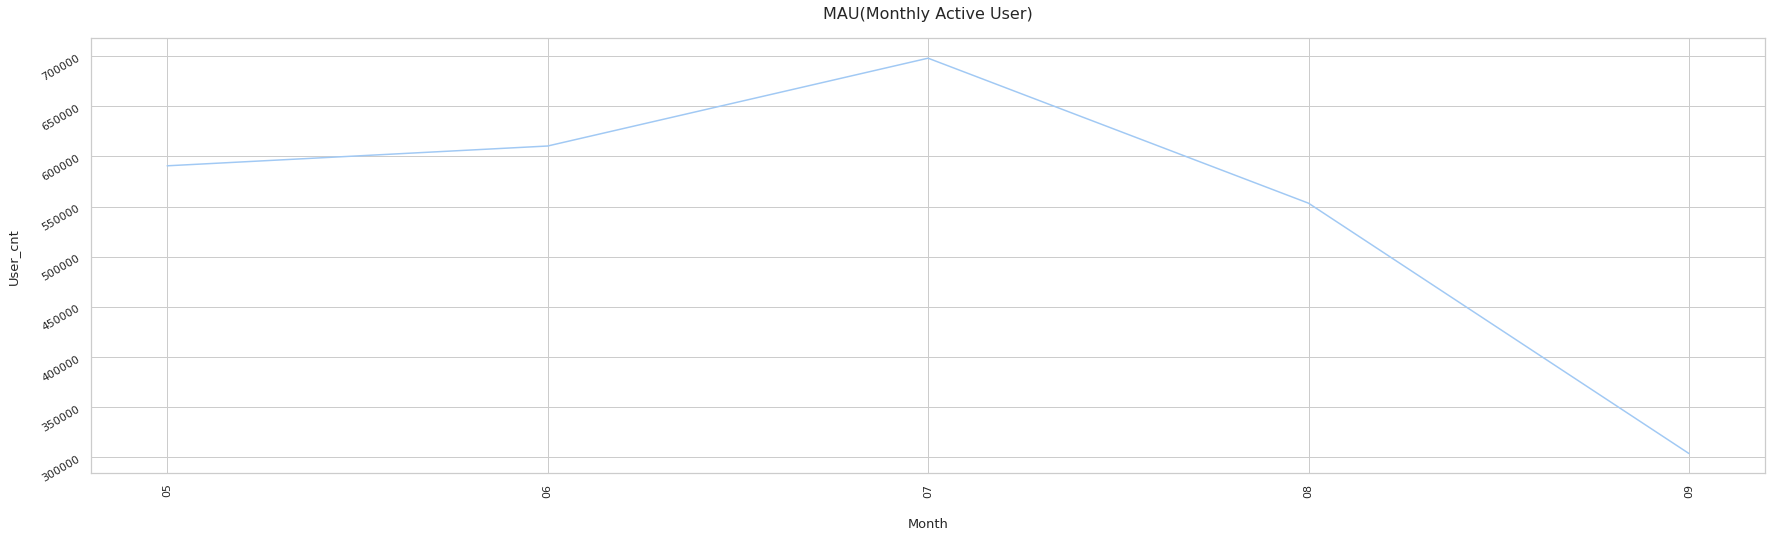

In [26]:
# MAU
MAU = events.groupby('month')['visitorid'].count().reset_index().rename(columns = {'visitorid':'cnt_visit'})

sns.set_theme(style="whitegrid", palette="pastel")
plt.xticks(rotation=90)
plt.yticks(rotation=30) 

g = sns.lineplot(x='month', y='cnt_visit',data =MAU)
g.figure.set_size_inches(30, 8)
g.xaxis.set_major_locator(ticker.MultipleLocator(1))

g.set_title("MAU(Monthly Active User)", pad=20, size=16)
g.set_xlabel("Month",labelpad = 20, size = 13)
g.set_ylabel("User_cnt",labelpad = 20, size = 13)

In [27]:
# dau/mau
print('DAU : ',DAU['cnt_visit'].mean())
print('MAU : ',MAU['cnt_visit'].mean())
print('DAU/MAU : ',DAU['cnt_visit'].mean()/MAU['cnt_visit'].mean() )

# dau/mau가 거의 1/30에 가깝다. 즉, 고객의 재방문율이 떨어진다.
# 하지만, 데이터의 맹점이 있다. 9월 MAU가 상당히 떨어지는 이유는, 9월 17일까지의 데이터까지 온전하기 때문이다.
# 따라서, 9월의 Data를 아예 지우든, 혹은 대체값을 만들든(ex. 9월MAU * 30/17) 해서 수행하는것이 올바르다.


DAU :  19828.06474820144
MAU :  551220.2
DAU/MAU :  0.03597122302158274


#### Cohort 분석

In [28]:
first_come_date = events[['visitorid','date']].drop_duplicates(subset = 'visitorid', keep = 'first')
first_come_date.reset_index(drop = True,inplace=True)
first_come_date = first_come_date.rename(columns ={'date':'first_date'})
first_come_date

## 275만개 data -> 140만개 data

,visitorid,first_date
0,693516,2015-05-03
1,829044,2015-05-03
2,652699,2015-05-03
3,1125936,2015-05-03
4,1149227,2015-05-03
...,...,...
1407575,998517,2015-09-18
1407576,472345,2015-09-18
1407577,1207677,2015-09-18
1407578,255126,2015-09-18


In [249]:
cohort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2756101 entries, 0 to 2756100
Data columns (total 10 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      int64         
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
 5   datetime       datetime64[ns]
 6   date           datetime64[ns]
 7   month          object        
 8   week           object        
 9   first_date     datetime64[ns]
dtypes: datetime64[ns](3), float64(1), int64(3), object(3)
memory usage: 231.3+ MB


In [281]:
cohort = events.merge(first_come_date, how = 'left',on = 'visitorid')

## data type 변경
# cohort['date'] = cohort['date'].map(pd.to_datetime)
cohort['first_date']= pd.to_datetime(cohort['first_date'])
cohort['date']= pd.to_datetime(cohort['date'])
cohort['month'] = cohort['date'].dt.to_period('M')
cohort['first_month'] = cohort['first_date'].dt.to_period('M')

# term col 추가
cohort['term'] = cohort['date'] - cohort['first_date']
cohort.head()

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days


In [282]:
# 2회 이상 transaction이 된 경우 확인
cohort.loc[(cohort['event'] == 'transaction','visitorid')].value_counts()
# cohort[~(cohort['transactionid'].isna())].groupby('visitorid')['visitorid'].count()
# max 559회

# cohort[~(cohort['transactionid'].isna())].groupby('visitorid')['visitorid'].count().mean()
# # 평균 1.9162897858179027회

1150086    559
152963     349
530559     286
684514     189
861299     188
          ... 
356340       1
835566       1
266350       1
1083369      1
1300499      1
Name: visitorid, Length: 11719, dtype: int64

In [283]:
# 몇 회의 transaction이 발생했는지 확인하기 위한 count column
cohort['transaction_cnt'] = 0 # 0으로 초기화

# 고객 별 transaction 횟수
# time 기준으로 정렬되어있으므로, rank 함수로 처리함
cohort.loc[(~cohort['transactionid'].isna(), 'transaction_cnt')] =\
cohort[~cohort['transactionid'].isna()].groupby('visitorid')['transaction_cnt'].rank(method = 'first') # -------- ★ 


In [284]:
# last visit
cohort['last_visit'] = cohort.groupby('visitorid')['date'].shift(1)

# cohort['last_visit']= cohort['last_visit'].fillna(cohort['date'])
cohort

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,first_month,term,transaction_cnt,last_visit
0,1430622004384,693516,addtocart,297662,NaN,2015-05-03 03:00:04.384,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT
1,1430622011289,829044,view,60987,NaN,2015-05-03 03:00:11.289,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT
2,1430622013048,652699,view,252860,NaN,2015-05-03 03:00:13.048,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT
3,1430622024154,1125936,view,33661,NaN,2015-05-03 03:00:24.154,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,NaT
4,1430622026228,693516,view,297662,NaN,2015-05-03 03:00:26.228,2015-05-03,2015-05,2015-w18,2015-05-03,2015-05,0 days,0.0,2015-05-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756096,1442545164029,472345,view,301436,NaN,2015-09-18 02:59:24.029,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT
2756097,1442545165499,1207677,view,310922,NaN,2015-09-18 02:59:25.499,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT
2756098,1442545174109,255126,view,47467,NaN,2015-09-18 02:59:34.109,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT
2756099,1442545181778,622226,view,345308,NaN,2015-09-18 02:59:41.778,2015-09-18,2015-09,2015-w37,2015-09-18,2015-09,0 days,0.0,NaT


In [285]:
cohort['term_month'] = cohort['term'].dt.days # timedelta -> int로 변경
cohort['term_month'] = cohort['term_month']//30
cohort['term_month']

0          0
1          0
2          0
3          0
4          0
          ..
2756096    0
2756097    0
2756098    0
2756099    0
2756100    0
Name: term_month, Length: 2756101, dtype: int64

In [286]:
df_cohort[df_cohort['term_month']==1]

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,fist_month,term,transaction_cnt,last_visit,term_month
4953,1433273162266,163561,transaction,114121,9120.0,2015-06-02 19:26:02.266,2015-06-02,2015-06,2015-w22,2015-05-03,2015-05,30 days,79.0,2015-06-02,1
4982,1433280283528,163561,transaction,41422,10529.0,2015-06-02 21:24:43.528,2015-06-02,2015-06,2015-w22,2015-05-03,2015-05,30 days,80.0,2015-06-02,1
4985,1433281061118,163561,transaction,44001,30.0,2015-06-02 21:37:41.118,2015-06-02,2015-06,2015-w22,2015-05-03,2015-05,30 days,81.0,2015-06-02,1
5019,1433290973503,138131,transaction,36995,12711.0,2015-06-03 00:22:53.503,2015-06-03,2015-06,2015-w22,2015-05-04,2015-05,30 days,83.0,2015-06-03,1
5020,1433290973503,138131,transaction,105334,12711.0,2015-06-03 00:22:53.503,2015-06-03,2015-06,2015-w22,2015-05-04,2015-05,30 days,84.0,2015-06-03,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22452,1442542096512,152963,transaction,12504,5772.0,2015-09-18 02:08:16.512,2015-09-18,2015-09,2015-w37,2015-07-31,2015-07,49 days,345.0,2015-09-18,1
22453,1442542096512,152963,transaction,72462,5772.0,2015-09-18 02:08:16.512,2015-09-18,2015-09,2015-w37,2015-07-31,2015-07,49 days,346.0,2015-09-18,1
22454,1442542096528,152963,transaction,380196,5772.0,2015-09-18 02:08:16.528,2015-09-18,2015-09,2015-w37,2015-07-31,2015-07,49 days,347.0,2015-09-18,1
22455,1442543898098,152963,transaction,362697,5670.0,2015-09-18 02:38:18.098,2015-09-18,2015-09,2015-w37,2015-07-31,2015-07,49 days,348.0,2015-09-18,1


In [287]:
df_cohort[(df_cohort['month'] == '2015-05')&df_cohort['term_month']>0]

,timestamp,visitorid,event,itemid,transactionid,datetime,date,month,week,first_date,fist_month,term,transaction_cnt,last_visit,term_month


In [338]:
df_cohort = cohort[~cohort['transactionid'].isna()].reset_index(drop=True)
cohort_vis = df_cohort[['first_month','term_month','visitorid']].drop_duplicates().reset_index(drop = True).groupby(['first_month','term_month']).count().rename(columns ={'visitorid':'count_visit'})
cohort_vis = cohort_vis.unstack()
cohort_vis.columns = cohort_vis.columns.droplevel(0) # multi-index 제거
cohort_vis = cohort_vis.divide(cohort_vis[0],axis=0) # 첫달껄로 다 나눠주기
cohort_vis

term_month,0,1,2,3,4
first_month,,,,,
2015-05,1.0,0.069455,0.050037,0.032114,0.007095
2015-06,1.0,0.038073,0.025641,0.006605,NaN
2015-07,1.0,0.033110,0.004092,NaN,NaN
2015-08,1.0,0.008559,NaN,NaN,NaN
2015-09,1.0,NaN,NaN,NaN,NaN


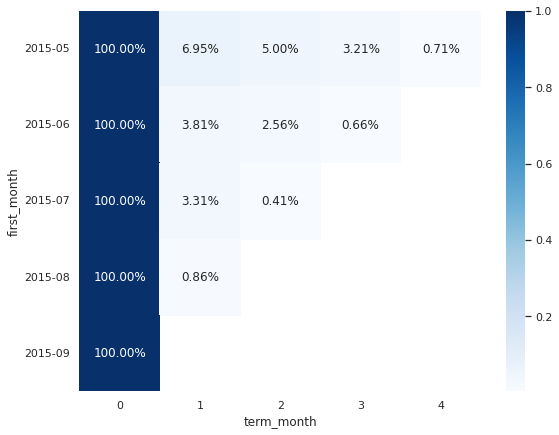

In [340]:
sns.set_theme(style="whitegrid", palette="pastel")
g = sns.heatmap(cohort_vis, annot=True, fmt='.2%', cmap="Blues")
g.figure.set_size_inches(9, 7) 

#### ✅df_item

In [ ]:
df_item.sort_values('timestamp',inplace=True)
df_item.reset_index(drop=True, inplace = True)
df_item.head()

,timestamp,itemid,property,value,datetime,date
0,1431226800000,317951,790,n32880.000,2015-05-10 03:00:00,2015-05-10
1,1431226800000,422842,480,1133979,2015-05-10 03:00:00,2015-05-10
2,1431226800000,310185,776,103591,2015-05-10 03:00:00,2015-05-10
3,1431226800000,110973,112,679677,2015-05-10 03:00:00,2015-05-10
4,1431226800000,179597,available,0,2015-05-10 03:00:00,2015-05-10


In [ ]:
df_item[df_item['itemid']==243157]

,timestamp,itemid,property,value,datetime,date
19387056,1441508400000,243157,678,567465,2015-09-06 03:00:00,2015-09-06
19394072,1441508400000,243157,categoryid,333,2015-09-06 03:00:00,2015-09-06
19489934,1441508400000,243157,888,923712,2015-09-06 03:00:00,2015-09-06
19600934,1441508400000,243157,283,648307 567465 923712 659000 639502 312815 8107...,2015-09-06 03:00:00,2015-09-06
19604757,1441508400000,243157,790,n507120.000,2015-09-06 03:00:00,2015-09-06
19635543,1441508400000,243157,764,1285872,2015-09-06 03:00:00,2015-09-06
19806090,1442113200000,243157,112,679677,2015-09-13 03:00:00,2015-09-13
19811541,1442113200000,243157,6,250259 1037547,2015-09-13 03:00:00,2015-09-13
19937137,1442113200000,243157,364,1326957,2015-09-13 03:00:00,2015-09-13
19957934,1442113200000,243157,917,923712,2015-09-13 03:00:00,2015-09-13
